In [1]:
import os
os.chdir(os.getenv("WORKINGDIR"))
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from astropy.io import fits
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from skipper_image_analysis.utils import plot_ccd_image, mask_baseline_error, BLUE_CUBE_CMAP

# Matplotlib settings
%config InlineBackend.figure_format = "retina"  # For high dpi figures in notebook
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["figure.dpi"] = 120
plt.rcParams["legend.fontsize"] = "medium"
plt.rcParams["axes.labelsize"] = "large"

# Global variables
NCOL = 336  # Number of columns in a CCD frame (overscan included)
NROW = 829  # Number of rows in a CCD frame
OVERSCAN_LENGTH = 50  # Number of overscan pixels

data_dict = {
    "standard": "skipper_data/TRAPS/29JUN2023",
    "shutter": "skipper_data/TRAPS/03JUL2023",
    "cloth": "skipper_data/TRAPS/13JUL2023",
    "fixed" : "skipper_data/TRAPS/29SEP2023",
    "half_open" : "skipper_data/TRAPS/03OCT2023/"
}

### Análisis de Fondo

In [2]:
prescan_and_error_length = 40  # ~8 pixels from prescan + ~30 from an unknow error
config_results = dict()
config_images = dict()
for config in tqdm(["standard", "shutter", "cloth", "fixed", "half_open" ], desc="Configuración"):
    files_in_dir = os.listdir(data_dict[config])
    dats_in_dir = set([file[:-6] for file in files_in_dir if file[-3:] == "dat"])
    exposure_values = np.arange(300, 1800+1, 300)  # s
    median_images = []
    for m_exposure, exposure in tqdm(enumerate(range(300, 1800+1, 300)),
                                     desc="Exposición", leave=False, total=6):
        file_names = []
        for name in files_in_dir:
            valid_file = (
                (name[:4] == "proc") and (name[5:-5] not in dats_in_dir)
            )
            if (f"EXPOSURE{exposure}" in name) and valid_file:
                file_names.append(name)
        frame_image_array = [
            np.zeros((NROW, NCOL-OVERSCAN_LENGTH-prescan_and_error_length, len(file_names))) for _ in range(4)
        ]
        for n_file, file in enumerate(file_names):
            image = fits.open(f'{data_dict[config]}/{file}')
            # Extract median for each column to fix pre-scan effect
            # & remove overscan
            for i_frame in range(4):
                frame = image[i_frame].data[:, prescan_and_error_length:-OVERSCAN_LENGTH]
                frame = mask_baseline_error(frame)
                frame_image_array[i_frame][:, :, n_file] = frame
        median_frames = [np.nanmedian(hyperframe, axis=2) for hyperframe in frame_image_array]
        median_images.append(
            median_frames,
        )
    config_images[config] = median_images

Configuración:   0%|          | 0/5 [00:00<?, ?it/s]

Exposición:   0%|          | 0/6 [00:00<?, ?it/s]

Exposición:   0%|          | 0/6 [00:00<?, ?it/s]

Exposición:   0%|          | 0/6 [00:00<?, ?it/s]

Exposición:   0%|          | 0/6 [00:00<?, ?it/s]

Exposición:   0%|          | 0/6 [00:00<?, ?it/s]

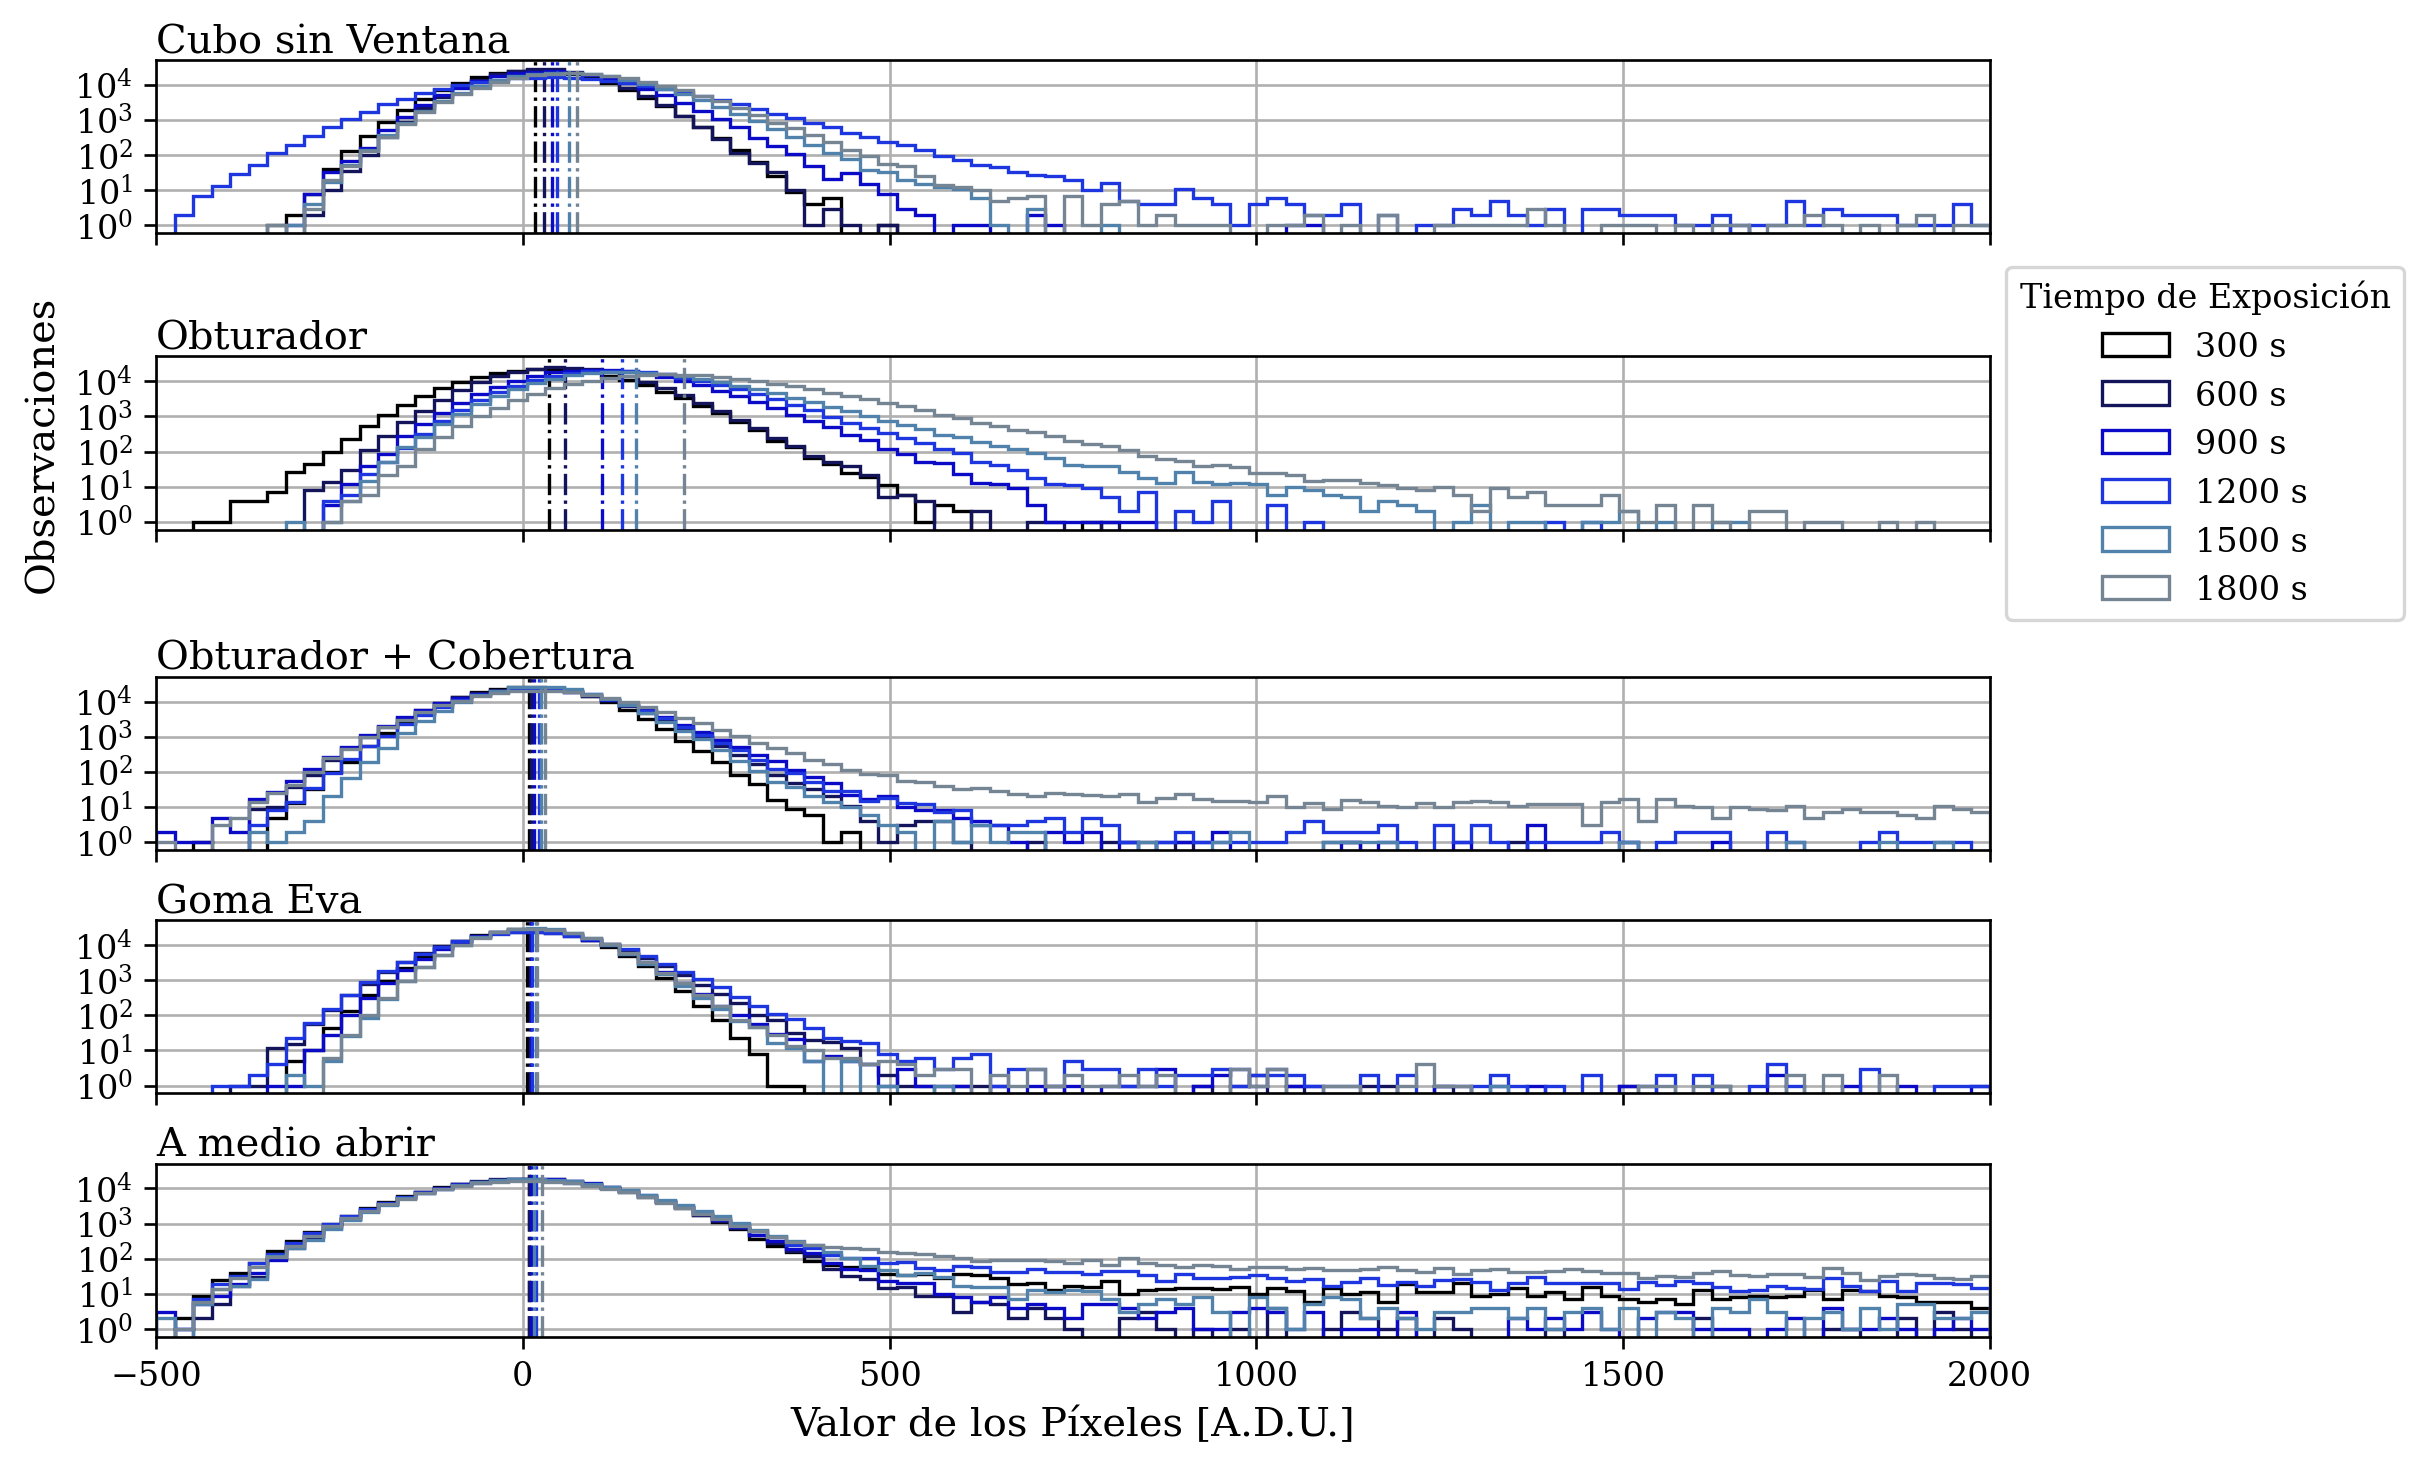

In [3]:
tags = {
    "standard": "Cubo sin Ventana",
    "shutter": "Obturador",
    "cloth": "Obturador + Cobertura",
    "fixed": "Goma Eva",
    "half_open": "A medio abrir"
}

norm = Normalize(300, 1.2*1800)
colorscale = plt.cm.ScalarMappable(norm, BLUE_CUBE_CMAP).to_rgba

min_val = -5e2
tope = 2e3
n_bins = 100
fig, axs = plt.subplots(5, 1, figsize=(10, 6), constrained_layout=True, sharex=True, sharey=True)
for ax, config in zip(axs, tags.keys()):
    for i, exposure in enumerate(np.arange(300, 1800+1, 300)):
        # if exposure in [1200]:
        #     continue
        test_data = config_images[config][i][0].flatten()
        test_data = test_data[~np.isnan(test_data)]
        ax.hist(
            test_data[np.abs(test_data) < tope],
            bins=np.linspace(min_val, tope, n_bins),
            histtype="step",
            label=f"{exposure} s",
            color=colorscale(exposure),
            
        )
        ax.axvline(np.nanmedian(test_data), ls="-.", c=colorscale(exposure), lw=1)
    ax.grid(True)
    ax.set_yscale("log")
    ax.set_yticks(10**np.arange(5))
    ax.set_xlim(min_val, tope)
    ax.set_title(tags[config], loc="left", pad=-1)  
    
ax.set_xlabel("Valor de los Píxeles [A.D.U.]")
axs[1].legend(title="Tiempo de Exposición", bbox_to_anchor=(1, 0.5), loc="center left")
axs[1].set_ylabel("Observaciones")
fig.savefig("skipper_data/figuras_informe/median_images_dist.png", dpi=300)
plt.show()

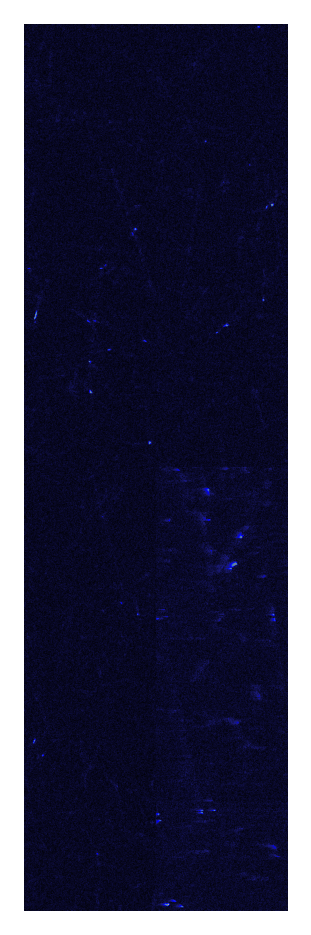

In [4]:
plot_ccd_image(config_images["fixed"][3], orientation="vertical", remove_overscan=False)
plt.show()

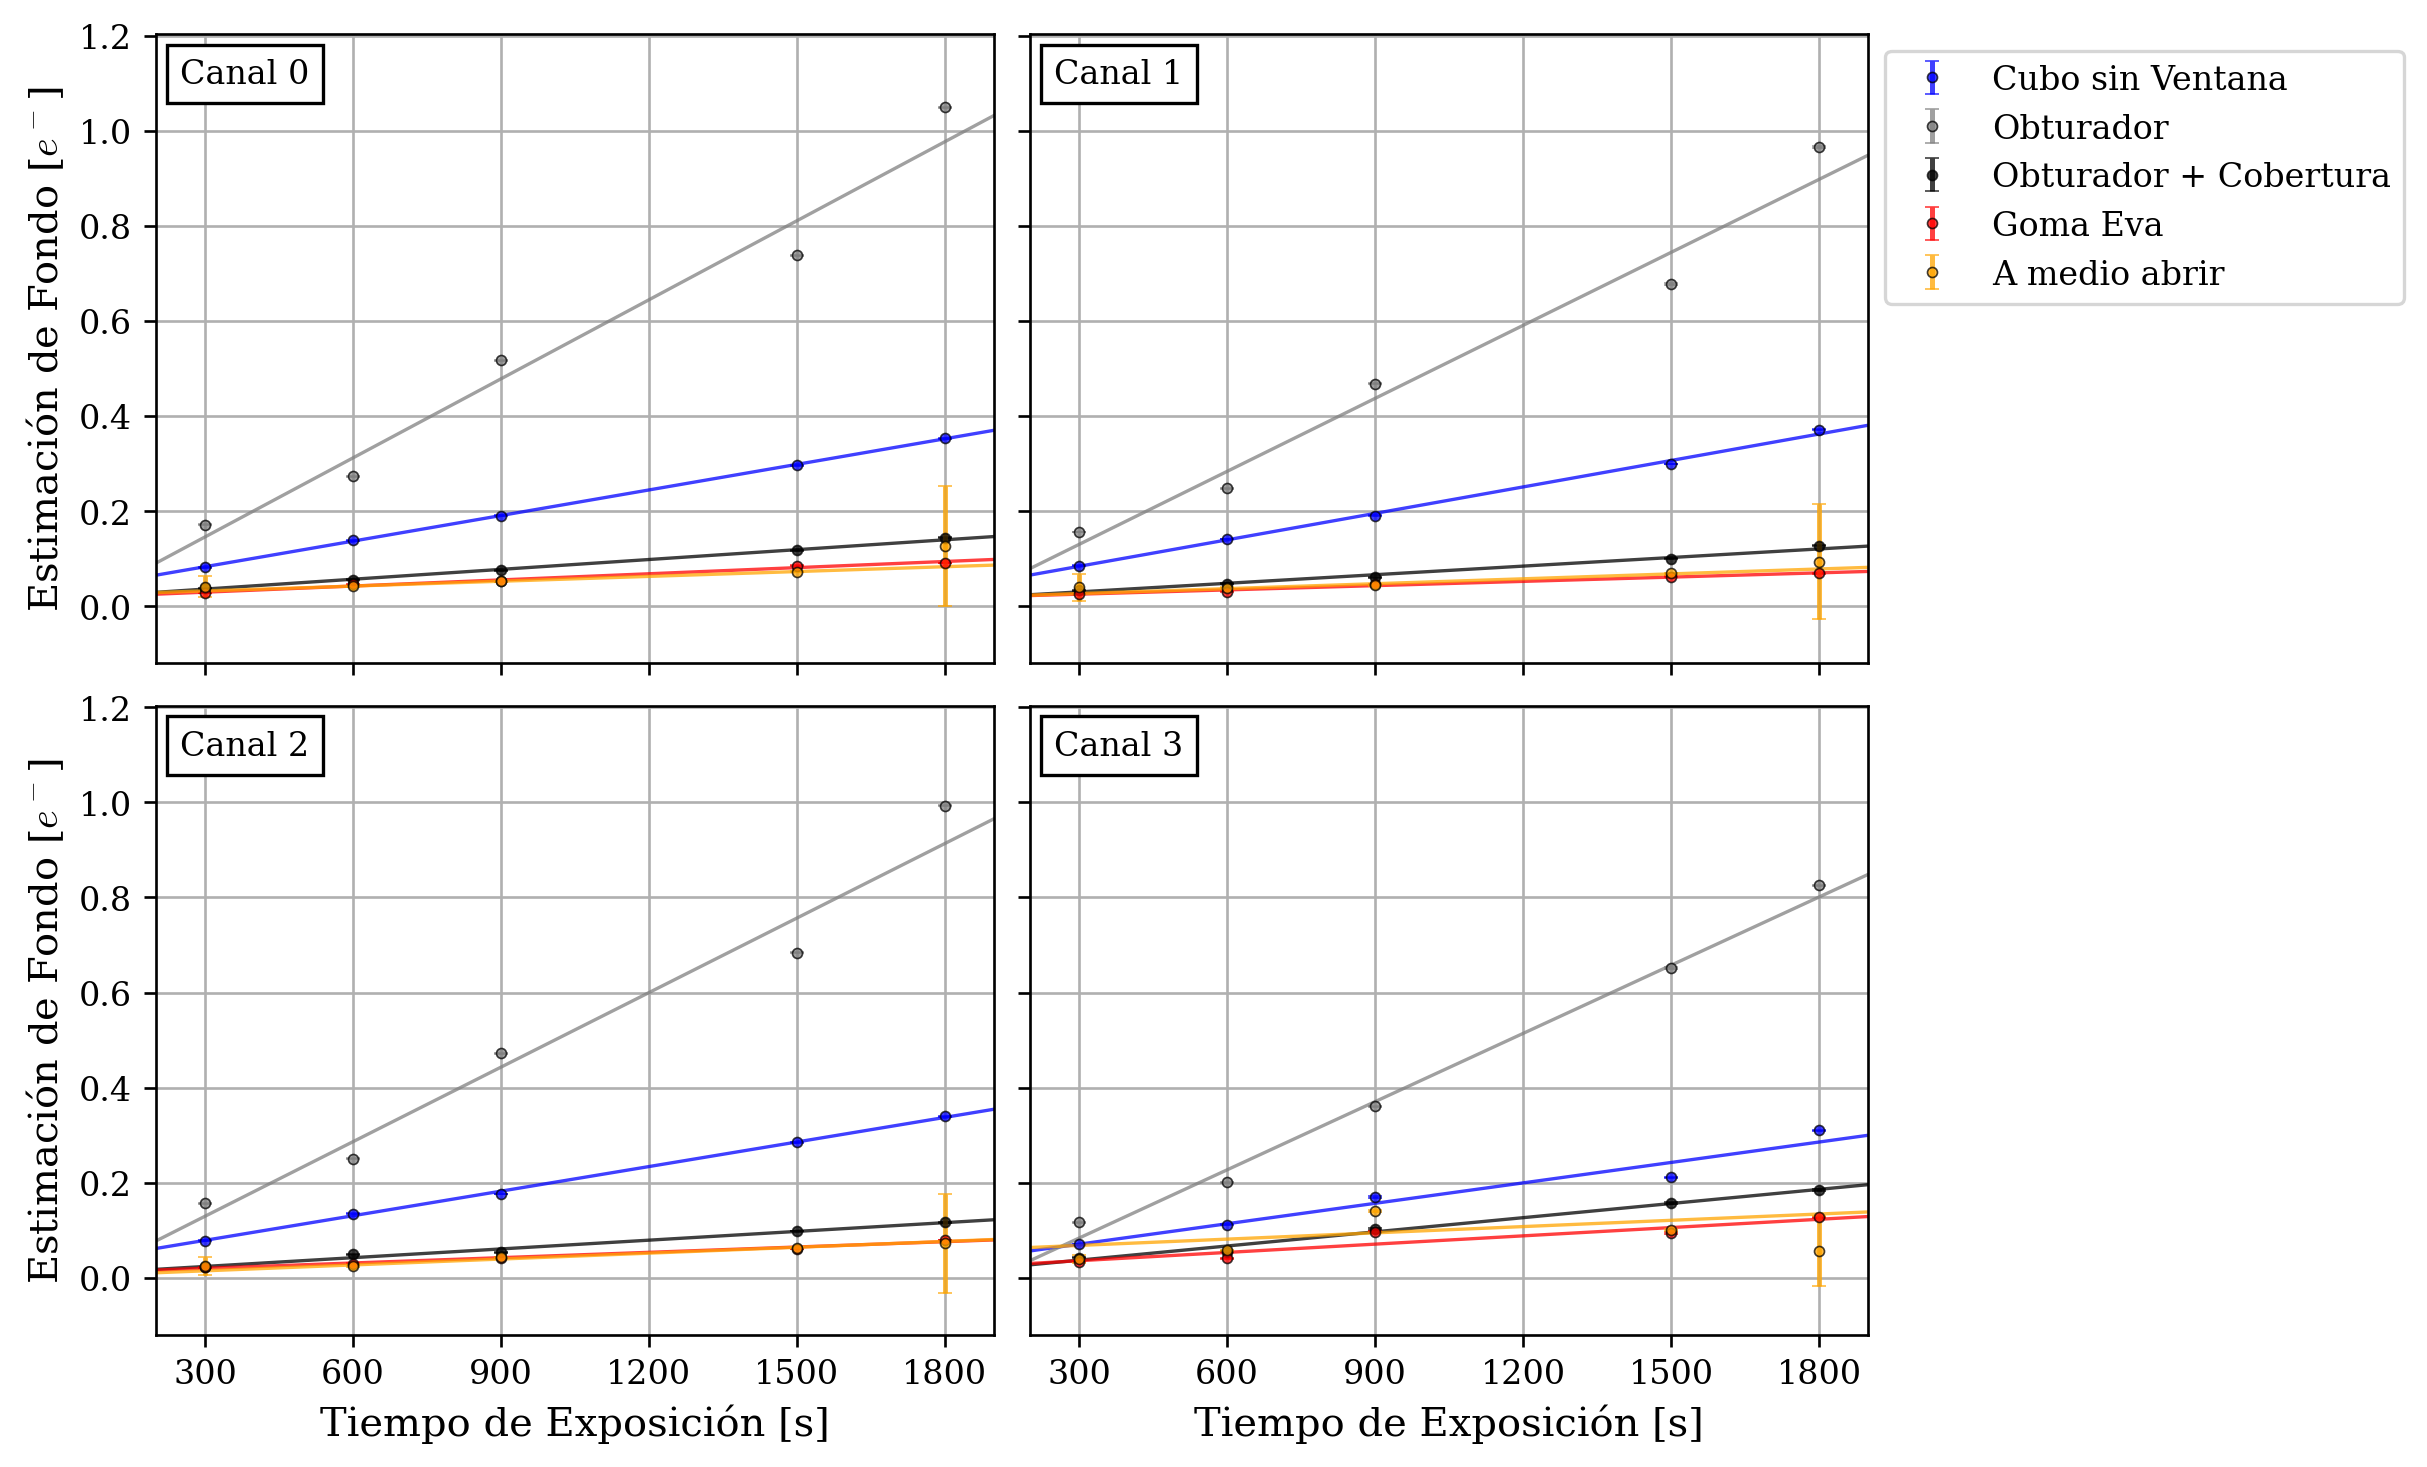

In [12]:
color_dict = {
    "standard": "blue",
    "shutter": "gray",
    "cloth": "k",
    "fixed": "red",
    "half_open": "orange"
}
tags = {
    "standard": "Cubo sin Ventana",
    "shutter": "Obturador",
    "cloth": "Obturador + Cobertura",
    "fixed": "Goma Eva",
    "half_open": "A medio abrir"
}
ganancia = {
    0: 210,
    1: 232,
    2: 207,
    3: 159
}

fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True, constrained_layout=True)
for i, ax in enumerate(axs.flatten()):
    ax.text(250, 1.1, f"Canal {i}", bbox=dict(fc="w", ec="k"))
    ax.grid(True)
    if not i % 2:
        ax.set_ylabel("Estimación de Fondo [$e^-$]")
    if i > 1:
        ax.set_xlabel("Tiempo de Exposición [s]")
    ax.set_xlim(200, 1800+100)
    ax.set_xticks(exposure_values)
    # ax.set_yticks(np.arange(-100, 300+1, 100))
# ax.set_ylim(-25, 300)

fit_params = dict()
exposures_filter = (exposure_values != 1200)# & (exposure_values != 1800)
for config in ["standard", "shutter", "cloth", "fixed", "half_open"]:
    pendientes = []
    for frame_idx, ax in enumerate(axs.flatten()):
        frame_pixel_list = [exp_frame_list[frame_idx].flatten() for exp_frame_list in config_images[config]]
        y_vals = np.array([np.nanmedian(pixels) for pixels in frame_pixel_list])[exposures_filter]/ganancia[frame_idx]
        filtered_frame_pixel_list = [
            pixels[pixels < np.nanquantile(pixels, 0.99)] for pixels in frame_pixel_list
        ]
        y_err = np.array([
            np.nanstd(pixels, ddof=1) / np.sqrt(np.sum(~np.isnan(pixels)))
            for pixels in filtered_frame_pixel_list
        ])[exposures_filter]/ganancia[frame_idx]
        popt, pcov = curve_fit(
            lambda x, a, b: a*x + b,
            (exposure_values[exposures_filter]),#+60*3),
            y_vals,
            sigma=y_err,
        )
        if frame_idx != 3:
            pendientes.append(popt[0])
        # print(f"{config}, frame {frame_idx}: {popt[0]:.3g} ± {np.sqrt(pcov[0, 0]):.1g}")
        ax.errorbar(
            x=(exposure_values[exposures_filter]),# + 60*3),  # Adding 3 minutes of average readout time
            y=y_vals, 
            yerr=y_err,
            fmt="o",
            color=color_dict[config],
            ms=3,
            markeredgecolor="k",
            markeredgewidth=0.5,
            alpha=0.75,
            ecolor=color_dict[config],
            capsize=2,
            label=tags[config],
        )
        ax.plot(
            [0, 1800+300],
            [popt[0]*i + popt[1] for i in [0, 1800+300]],
            color=color_dict[config],
            alpha=0.75,
            lw=1,
        )
        # ax.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False)
    fit_params[config] = np.mean(pendientes), np.std(pendientes, ddof=1)
axs[0, 1].legend(loc="upper left", bbox_to_anchor=(1, 1))
# fig.savefig("skipper_data/figuras_informe/background_level.png", dpi=300)
plt.show()

In [6]:
for k, v in fit_params.items():
    print(f"{k}: {v[0]:.3f} ± {v[1]:.1g}")

standard: 0.039 ± 0.004
shutter: 0.114 ± 0.006
cloth: 0.014 ± 0.0009
fixed: 0.008 ± 0.001
half_open: 0.008 ± 0.0007


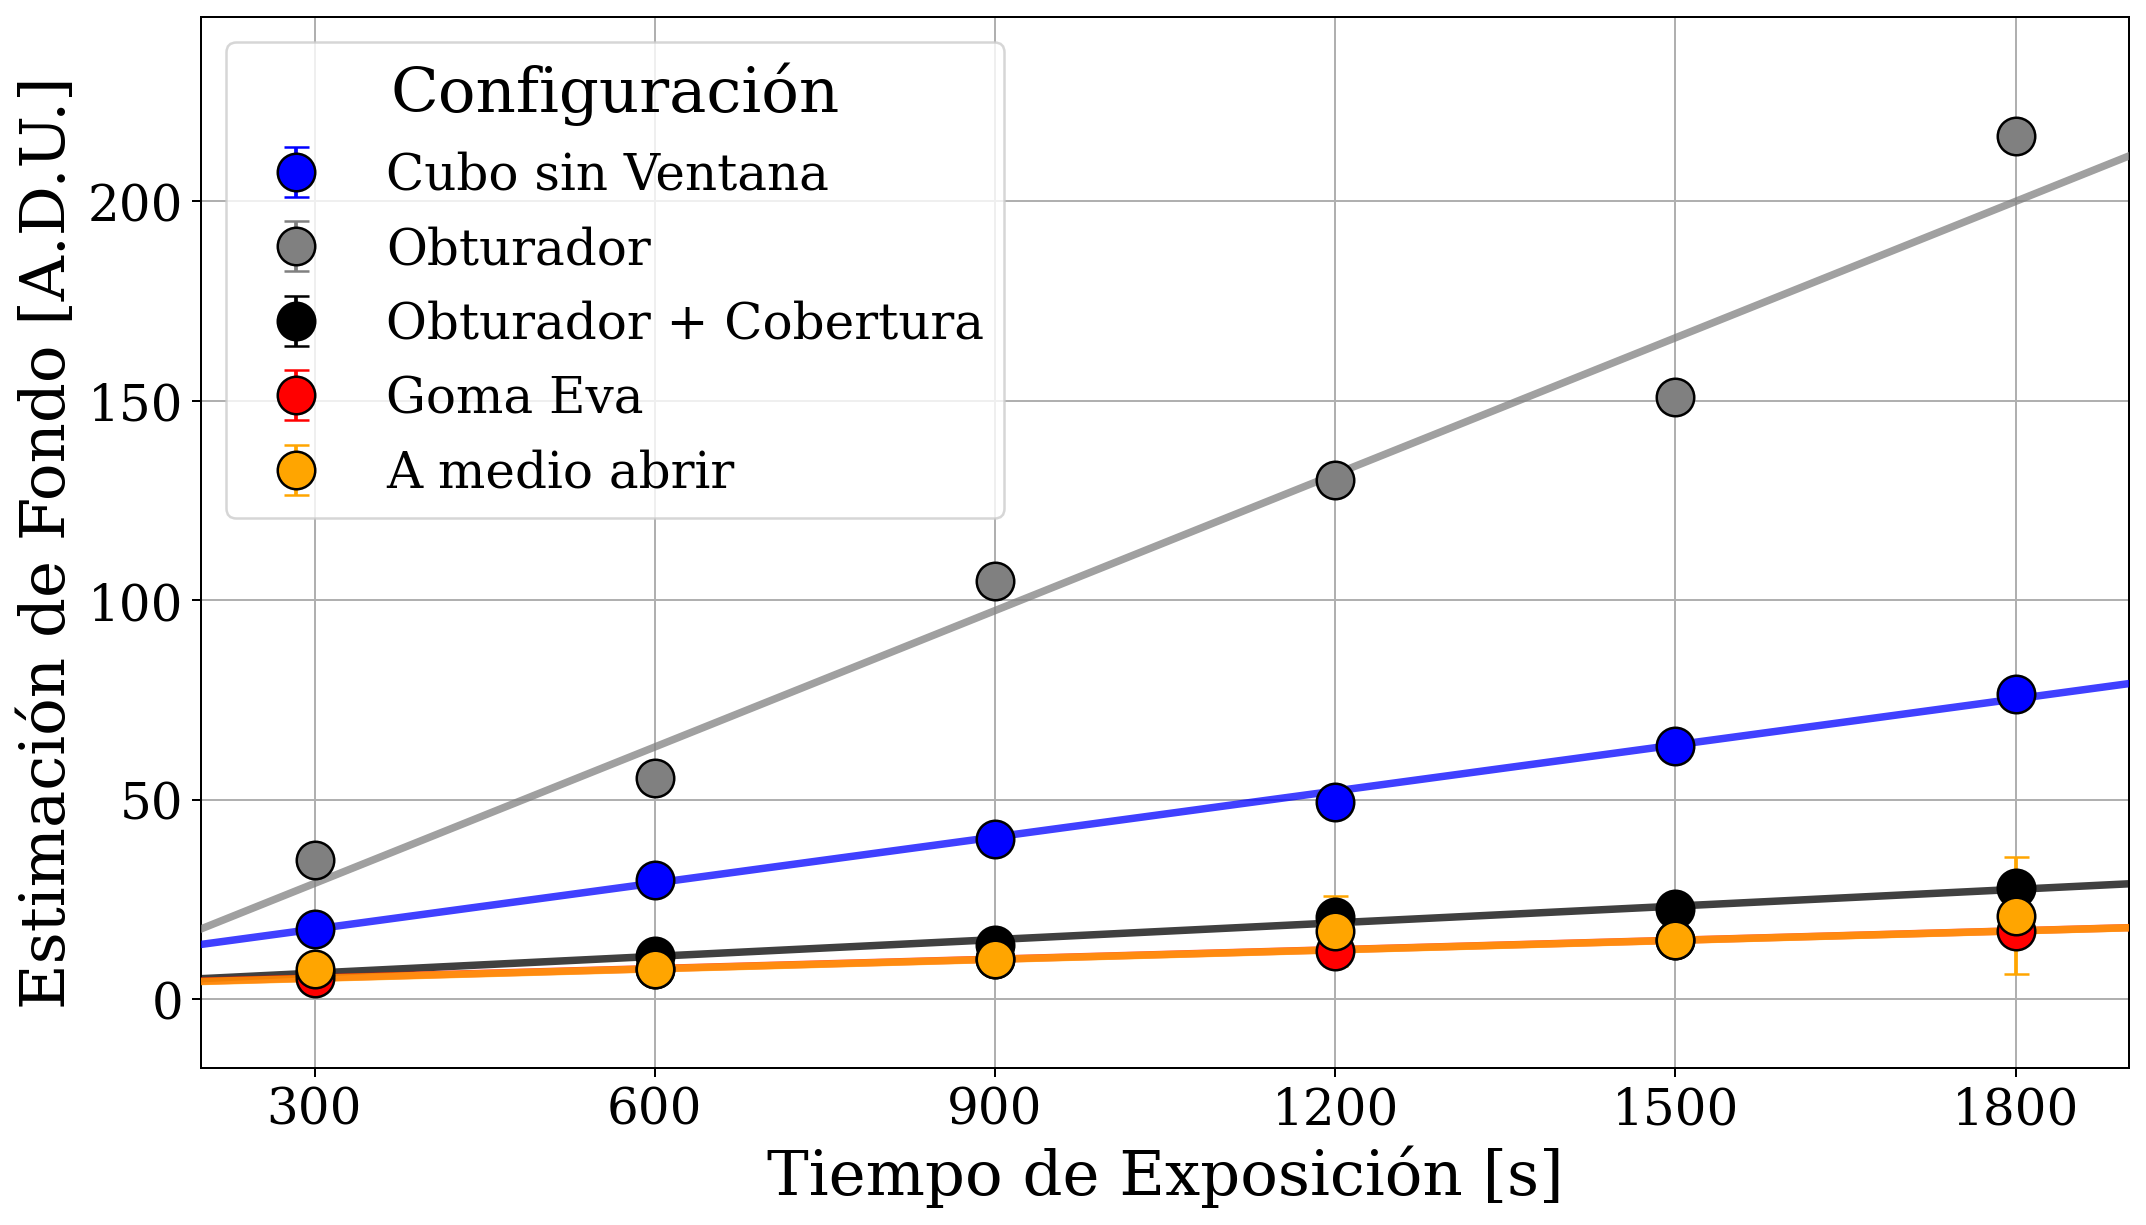

In [7]:
color_dict = {
    "standard": "blue",
    "shutter": "gray",
    "cloth": "k",
    "fixed": "red",
    "half_open": "orange"
}
tags = {
    "standard": "Cubo sin Ventana",
    "shutter": "Obturador",
    "cloth": "Obturador + Cobertura",
    "fixed": "Goma Eva",
    "half_open": "A medio abrir"
}
# Creates a figure with a transparent background
fig, ax = plt.subplots(1, 1, dpi=90, constrained_layout=True, facecolor="none")
fig.set_size_inches(30/2.54, 17/2.54)
ax.grid(True)
ax.set_ylabel("Estimación de Fondo [A.D.U.]", fontsize=25)
ax.set_xlabel("Tiempo de Exposición [s]", fontsize=25)
ax.set_xlim(200, 1800+100)
ax.set_xticks(exposure_values)
ax.tick_params(labelsize=20)
for config in ["standard", "shutter", "cloth", "fixed", "half_open"]:
    frame_pixel_list = []
    for exp_idx, _ in enumerate(exposure_values):
        frame_list = []
        for frame_idx in range(3):
            frame_list.append(config_images[config][exp_idx][frame_idx].flatten())
        frame_pixel_list.append(np.concatenate(frame_list))
    y_vals = np.array([np.nanmedian(pixels) for pixels in frame_pixel_list])
    filtered_frame_pixel_list = [
        pixels[pixels < np.nanquantile(pixels, 0.99)] for pixels in frame_pixel_list
    ]
    y_err = np.array([
        np.nanstd(pixels, ddof=1) / np.sqrt(np.sum(~np.isnan(pixels)))
        for pixels in filtered_frame_pixel_list
    ])
    popt, pcov = curve_fit(
        lambda x, a, b: a*x + b,
        (exposure_values),#+60*3),
        y_vals,
        sigma=y_err,
    )
    # print(f"{config}, frame {frame_idx}: {popt[0]:.3g} ± {np.sqrt(pcov[0, 0]):.1g}")
    ax.errorbar(
        x=(exposure_values),# + 60*3),  # Adding 3 minutes of average readout time
        y=y_vals, 
        yerr=y_err,
        fmt="o",
        color=color_dict[config],
        ms=15,
        markeredgecolor="k",
        markeredgewidth=1,
        alpha=1,
        ecolor=color_dict[config],
        capsize=5,
        label=tags[config],
        zorder=5,
    )
    ax.plot(
        [0, 1800+300],
        [popt[0]*i + popt[1] for i in [0, 1800+300]],
        color=color_dict[config],
        alpha=0.75,
        lw=3,
        zorder=4
    )
    # ax.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False)
ax.legend(title="Configuración", fontsize=20, title_fontsize=25)
fig.savefig("skipper_data/background_level_poster.png", dpi=500)
plt.show()